## Рекомендательная система

### Цель

Предсказание рейтинга товаров на основе истории отзывов о них c целью увеличения чека продаж

## Содержание

[Ведение](#begin)

1. [Теоретические аспекты](#theory)

2. [Разведочный анализ данных](#EDA)

3. [Предобработка данных](#preproc)

4. [Создание и обучение моделей](#model)

  4.1. [Чистая коллаборативная фильтрация](#collab)
  
  4.2. [Гибридные модели](#hybrid)

5. [Выбор модели и подбор гиперпараметров](#params)

6. [Получение эмбеддингов](#embeddings)

7. [Проблема холодного старта](#start)

[Выводы](#end)

[Источники](#literature)


## Введение <a name="begin"></a>

Крупная компания, занимающаяся онлайн-ритейлом (розничными продажами в интернете), задалась целью увеличения среднего чека продаж. Чем точнее рекомендовать нужный товар пользователю (товар с более высоким средним чеком), тем выше вероятность покупки этого товара. 

Имеется история оценок пользователя вместе с его отзывом на товар. Можно использовать текст рецензии в качестве дополнительной информации. Все оценки пользователей нормированы для бинарной классификации: если человек поставил оценку продукту 4 и больше, считается, что продукт ему понравился, если меньше 4, то продукт не понравился.

## 1. Теоретические аспекты <a name="theory"></a>

В библиотеке LightFM реализована предиктивная модель рекомендательной системы на основе матричной факторизации. Модель позволяет представлять пользователей и предметы (товары) как линейные комбинации скрытых факторов их признаков. 
Библиотека позволяет создавать коллаборативные и основанные на контенте (с использованием метаданных о предметах и пользователях) модели и решать проблемы холодного старта и редких взаимодействий в исходной матрице.
Таким образом, получаются модели не хуже чисто коллаборативных матрично-факторизационных моделей на основе обильных данных. 
Кроме того, признаковые эмбеддинги, получаемые в результате обучения моделей, содержат в себе закодированную семантическую информацию подобно словарным эмбеддингам, что делает их полезными при решении многих связанных задач, таких как тэговые рекомендации. 
Например, если фильм "Wizard of Oz" описывается следующими признаками - "музыкальное фентези", "Judy Garland" и "Wizard of Oz", тогда его скрытое представление будет суммой скрытых представлений этих признаков. 

$U$ – множество пользователей

$I$ – множество предметов

$F^U$ – множество пользовательских признаков

$F^I$ – множество предметных признаков

Каждый пользователь взаимодействует с некоторым количеством предметов. При этом взаимодействие может быть позитивным или негативным. 
Множество всех взаимодействующих пар «пользователь – предмет»        $(u, i)  ∈ U × I$ представляет собой объединение позитивных $S^+$ и негативных $S^-$  взаимодействий.
Пользователи и предметы полностью описываются их признаками. Каждый пользователь $u$ описывается множеством признаков $f_u ⊂ F^U$ а каждый предмет – множеством признаков $f_i ⊂ F^I$. Признаки являются заранее известными и представлены в виде метаданных. 
Модель характеризуется наличием эмбеддингов: для каждого признака существуют $d$-мерные пользовательские эмбеддинги $e_f^U$  и предметные эмбеддинги $e_f^I$.  Каждый признак описывается также скалярным смещением ($b_f^U$ для пользовательских признаков и $b_f^I$ для предметных признаков). 

Скрытое представление пользователя u является суммой его признаковых скрытых векторов:
$$q_u =\sum\limits_{j∈f_u}^{}e_j^U$$ 
Скрытое представление предмета $i$ также является суммой его признаковых скрытых векторов:
$$p_i = \sum\limits_{j∈f_i}e_j^I$$ 
Смещение пользователя $u$ является суммой его признаковых смещений:
$$b_u = \sum\limits_{j∈f_u}b_j^U$$ 
Смещение предмета $i$ также является суммой его признаковых смещений:
$$b_i = \sum\limits_{j∈f_i}b_j^I$$ 

Предсказание модели для пользователя u и предмета i определяется скалярным произведением скрытых пользовательского и предметного представления, а также их смещениями: 
$$r ̂ _{ui} = f(q_u·p_i+b_u+b_i)$$
В качестве $f$ можно использовать многие функции. Например, тождественное отображение должно хорошо предсказывать целевую переменную. В случае бинарных данных предлагается применять сигмоиду:
$$f(x)=  \frac{1}{(1+exp⁡(-x))}$$
Задача оптимизации сводится к максимизации функции правдоподобия:
$$L(e^U,e^I,b^U,b^I )= \prod\limits_{(u,i)∈S^+}^{}r ̂_{ui}× \prod\limits_{(u,i)∈S^-}^{}(1-r ̂_{ui})$$
В библиотеке lightfM оптимизация реализуется посредством асинхронного стохастического градиентного спуска. 







## 2. Разведочный анализ данных <a name="EDA"></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd '/content/drive/My Drive/РЕАЛЬНЫЙ_DS/РЕКОМЕНДАТЕЛЬНАЯ_СИСТЕМА'

/content/drive/My Drive/РЕАЛЬНЫЙ_DS/РЕКОМЕНДАТЕЛЬНАЯ_СИСТЕМА


In [4]:
train = pd.read_csv('train.csv', low_memory = False)
test = pd.read_csv('test.csv', low_memory = False) 
df_train = train.copy()
df_test = test.copy()

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


- overall - рейтинг, который поставил пользователь
- verified - был ли отзыв верифицирован
- reviewTime - когда был отзыв написан
- reviewerName - имя пользователя
- reviewText - текст отзыва
- summary - сжатый отзыв
- vote - количество голосований за отзыв
- style - метаданные
- image - изображение продукта
- userid - id пользователя
- itemid - id товара
- id - id для предсказания

In [6]:
df_train.describe()

,overall,unixReviewTime,userid,itemid,rating
count,857895.000000,8.578950e+05,857895.000000,857895.000000,857895.000000
mean,4.441695,1.441755e+09,54573.200856,17080.473226,0.848927
std,1.064655,5.973571e+07,36799.421892,11441.176435,0.358120
min,1.000000,9.657792e+08,0.000000,0.000000,0.000000
25%,4.000000,1.411949e+09,21949.000000,6329.000000,1.000000
50%,5.000000,1.449101e+09,50015.000000,15935.000000,1.000000
75%,5.000000,1.484870e+09,85024.000000,26616.000000,1.000000
max,5.000000,1.538438e+09,127495.000000,41319.000000,1.000000


In [7]:
df_test.describe()

,unixReviewTime,userid,itemid,Id
count,2.859650e+05,285965.000000,285965.000000,285965.000000
mean,1.441818e+09,54435.397993,17083.395590,142982.000000
std,5.955711e+07,36760.083940,11427.621112,82551.129202
min,1.023322e+09,0.000000,0.000000,0.000000
25%,1.411949e+09,21829.000000,6329.000000,71491.000000
50%,1.449101e+09,49833.000000,15956.000000,142982.000000
75%,1.484870e+09,84785.000000,26615.000000,214473.000000
max,1.538438e+09,127495.000000,41319.000000,285964.000000


Все оценки пользователей нормированы для бинарной классификации, если человек поставил оценку продукту больше 3 (не включительно), то мы считаем, что продукт ему понравился, если меньше 4, то продукт не понравился.

В тестовом датасете, в отличие от тренировчного, отсутствуют столбцы:

In [ ]:
set(df_train.columns) - set(df_test.columns)

{'overall', 'rating', 'reviewText', 'summary'}

In [ ]:
df_train.head()

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [ ]:
df_test.head()

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


Количество уникальных значений:

In [ ]:
df_train.nunique()

overall                5
verified               2
reviewTime          4580
asin               41302
reviewerName      101207
reviewText        686739
summary           411451
unixReviewTime      4580
vote                 311
style              25892
image               6636
userid            127448
itemid             41302
rating                 2
dtype: int64

In [ ]:
df_test.nunique()

verified               2
reviewTime          4349
asin               37876
reviewerName       86815
unixReviewTime      4349
vote                 198
style              18904
image               2306
userid            109357
itemid             37876
Id                285965
dtype: int64

Определяем функции для построения графиков:

In [ ]:
sns.set_style("whitegrid")

In [ ]:
def countplot_1(df_input, feature):
    fig, ax = plt.subplots(figsize=(5,5)) 
    sns.countplot(x = feature, data = df_input)
    ax.set_xlabel(feature)
    ax.set_ylabel('number_of_ratings')

In [ ]:
def countplot_2(df_input, feature, size = (5,5), rotation = 0):
    fig, ax = plt.subplots(figsize = size) 
    sns.countplot(x = feature, hue = 'rating', data = df_input)
    ax.legend(ncol=2, title = 'rating', fontsize = 8)
    ax.set_xlabel(feature)
    ax.tick_params(axis = 'x', labelrotation = rotation)
    ax.set_ylabel('number_of_ratings')

In [ ]:
def hist_1(df_input, feature):
    df_input.groupby(feature).rating.mean().hist(bins = 100)
    plt.xlabel('mean_rating')
    plt.ylabel(f'number_of_{feature}s')

In [ ]:
def hist_2(df_input, feature): 
    df_input[df_input.rating == 1][feature].hist(bins = 100)
    df_input[df_input.rating == 0][feature].hist(bins = 100)
    plt.xlabel(feature)
    plt.ylabel('rating_number')
    plt.legend(('rating = 1', 'rating = 0'))

##### Rating

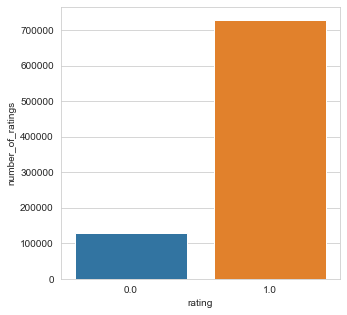

In [ ]:
countplot_1(df_train, 'rating')

В основном пользователи положительно оценивают товары. 

##### Overall

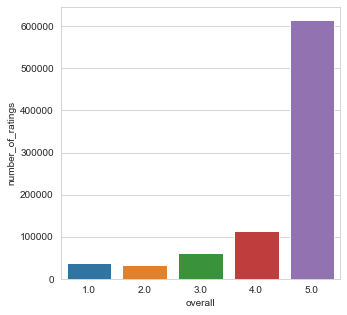

In [ ]:
countplot_1(df_train, 'overall')

В подавляющием большинстве случаев пользователи ставят товарам оценку 5.0.

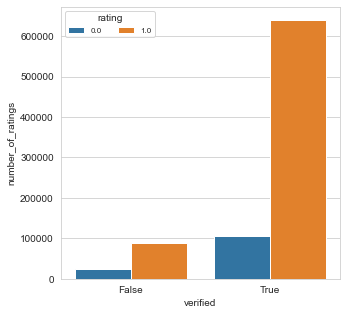

In [ ]:
countplot_2(df_train, 'verified')

Подавляющее большинство отзывов верифицировано. Положительных отзывов значительно больше как среди верифицированных, так и среди невирифицированных. 

##### reviewTime

In [ ]:
# Преобразование соответствующего столбца к формату даты
df_train.reviewTime = pd.to_datetime(df_train.reviewTime)

In [ ]:
# Извлечение информации о годе, месяце, дне недели отзыва
df_train['year'] = df_train.reviewTime.dt.year
df_train['month'] = df_train.reviewTime.dt.month
df_train['day_of_week'] = df_train.reviewTime.dt.dayofweek

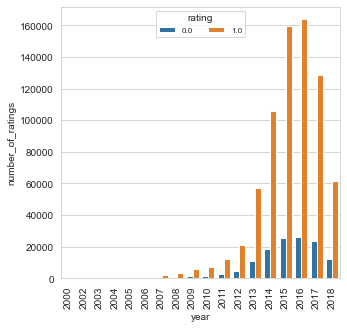

In [ ]:
countplot_2(df_train, 'year', rotation = 90)

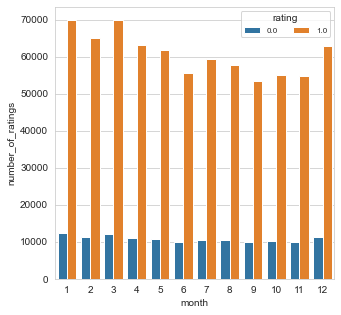

In [ ]:
countplot_2(df_train, 'month')

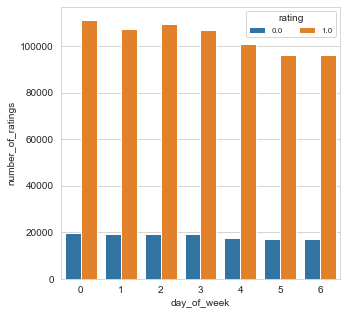

In [ ]:
countplot_2(df_train, 'day_of_week')

В период с 2000 г. по 2008 г. данных об оценках очень мало. Затем наблюдается рост их количества. Пик количества данных об оценках приходится на 2015 - 2016 г.г. Затем количество постепенно спадает вплоть до 2018 г.

По месяцам и дням недели количество данных распределено равномерно.

Во всех случаях количество положительных оценок значительно превосходит число отрицательных. 

#### reviewerName

In [ ]:
df_train[['reviewerName', 'userid']].nunique()

reviewerName    101207
userid          127448
dtype: int64

Видно, что количество имен пользователей (reviewerName) меньше, чем количество ID пользователей (userid), т.е. некоторые пользователи имеют одинаковые имена.

Имя / Количество оценок:

In [ ]:
df_train.reviewerName.value_counts()

Amazon Customer     31726
Kindle Customer      6228
Linda                 734
John                  725
David                 619
                    ...  
finicksyshopper         1
Osama Al Tarsha         1
qwertyuiop              1
Melodie Sheppard        1
Marc Daniels            1
Name: reviewerName, Length: 101207, dtype: int64

Пользователи с именем 'Amazon Customer' поставили больше всего оценок. Посмотрим на ID этих пользователей:

In [ ]:
df_train[df_train.reviewerName == 'Amazon Customer']['userid'].value_counts()

7477      89
1330      56
24035     56
8027      53
15752     48
          ..
62767      1
22369      1
115807     1
3253       1
105430     1
Name: userid, Length: 5329, dtype: int64

Количество пользователей с именем 'Amazon Customer' - 5329.

Рассмотрим распределение отзывов по двум именам, под которыми пользователи оставили больше всего отзывов:

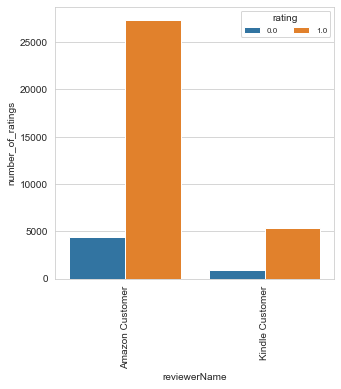

In [ ]:
countplot_2(df_train[df_train.reviewerName.isin(df_train.reviewerName.value_counts().index[:2])], 'reviewerName', rotation = 90)

Следующие 20 имен:

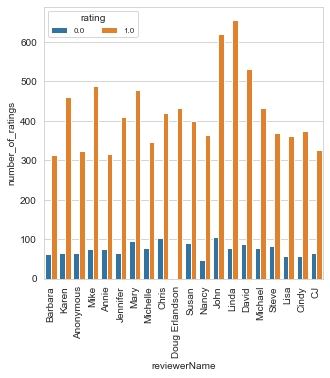

In [ ]:
countplot_2(df_train[df_train.reviewerName.isin(df_train.reviewerName.value_counts().index[2:22])], 'reviewerName', rotation = 90)

Как видно из графиков, характер распределения положительных и отрицательных отзывов для каждого имени одинаков - положительных отзывов значительно больше. 
При этом среди представленных имен есть одно - 'Doug Erlandson' - под которым оставлено всего 2 отрицательных отзыва из 435: 

In [ ]:
df_train[df_train.reviewerName == 'Doug Erlandson'].rating.value_counts()

1.0    433
0.0      2
Name: rating, dtype: int64

Посмотрим на распределение среднего рейтинга по именам пользователей:

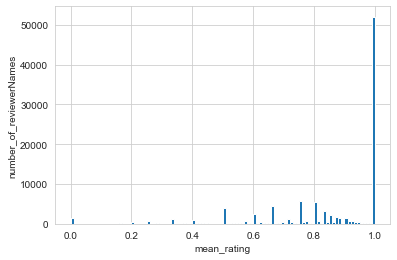

In [ ]:
hist_1(df_train, 'reviewerName')

Оказыватся, что в датасете около половины из всех имен (~52000 из 101207), под которыми пользователи оставляют практически только положительные оценки (средний рейтинг от 0.99 до 1.0). 
Есть и такие имена (их менее 1%), под которыми пользователи оценивают товары почти всегда отрицательно.

##### reviewText

Распределение количества положительных и отрицательных оценок по 50 самым распространенным текстам отзывов.

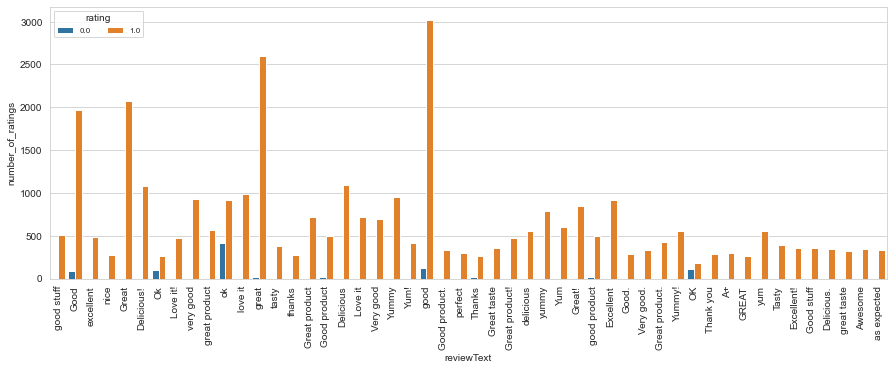

In [ ]:
countplot_2(df_train[df_train.reviewText.isin(df_train.reviewText.value_counts().index[:50])], 'reviewText', size = (15, 5), rotation = 90)

Видно, что в относительно небольшом количестве случаев текст отзыва является позитивным ('ОК', 'Good', 'Very good' и т.д.), однако оценки, сопряженные с этими отзывами, отрицательны (rating = 0). 

In [ ]:
df_train[(df_train.rating == 0) & (df_train.reviewText.isin(['OK', 'ok', 'Ok']))]

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day_of_week
3797,2.0,True,2017-04-23,B001D3PXSC,mac,ok,wrong kind,1492905600,NaN,NaN,NaN,19604,7229,0.0,2017,4,6
5173,2.0,False,2014-08-03,B0015P54R8,halina pietrzak,ok,Two Stars,1407024000,NaN,NaN,NaN,41579,6329,0.0,2014,8,6
7488,3.0,True,2017-11-05,B000CQ01NS,Amazon Customer,Ok,Three Stars,1509840000,NaN,NaN,NaN,33090,1218,0.0,2017,11,6
13737,3.0,True,2014-11-02,B0001GCAPQ,gerald soderquist,Ok,Three Stars,1414886400,NaN,NaN,NaN,10107,354,0.0,2014,11,6
14251,3.0,False,2016-11-03,B003SHKOJ4,TS,ok,Three Stars,1478131200,NaN,{'Flavor:': ' House Blend'},NaN,29617,11944,0.0,2016,11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848193,3.0,True,2018-01-13,B00X81JJP0,Stan Bowers,ok,Three Stars,1515801600,NaN,"{'Size:': ' 48 Count', 'Flavor:': ' Original B...",NaN,121729,33778,0.0,2018,1,5
849002,3.0,True,2016-10-13,B015Z8EWSW,Beatrice B.,OK,Three Stars,1476316800,NaN,NaN,NaN,111609,35535,0.0,2016,10,3
852187,3.0,True,2016-04-27,B000U0OUP6,Fawntella L. Scholz,Ok,Three Stars,1461715200,NaN,"{'Size:': ' 2 Lb 8.5 Ounce', 'Flavor:': ' Vari...",NaN,38881,4689,0.0,2016,4,2
852288,3.0,True,2015-10-15,B0078DQDA8,MARIA RIVERA,OK,HEALTHY,1444867200,NaN,NaN,NaN,14142,18205,0.0,2015,10,3


In [ ]:
# Создание столбца с длиной отзыва
df_train['reviewLength'] = df_train['reviewText'].apply(lambda x: len(str(x)))

Распределение количества отзывов в зависимости от их длины:

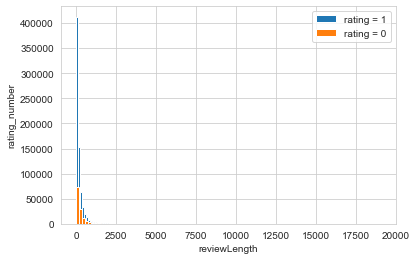

In [ ]:
hist_2(df_train, 'reviewLength')

Из гистограммы видно, что большая часть отзывов имеет длину менее 1000 символов. Рассмотрим более подробно распределение длин отзывов именно в этом диапазоне (<1000 символов):

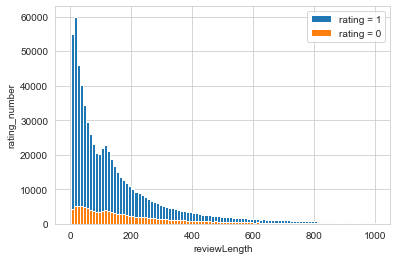

In [ ]:
hist_2(df_train[df_train['reviewLength'] < 1000], 'reviewLength')

Посмотрим на самый длинный отзыв:

In [ ]:
df_train[df_train['reviewLength'] == df_train['reviewLength'].max()]

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day_of_week,reviewLength
585803,2.0,True,2009-10-15,B001DEX99Q,Serendipity.,I am a sweet-aholic. That's my main downfall w...,The Real Review of Vitalicious Vitatops (Brown...,1255564800,95,NaN,NaN,35109,7270,0.0,2009,10,3,19057


In [ ]:
df_train[df_train['reviewLength'] == df_train['reviewLength'].max()]['reviewText'].iloc[0]

'I am a sweet-aholic. That\'s my main downfall when it comes to eating healthy, that and portion control. I love chocolate and decided to one day google "healthiest chocolate" and stumbled across Vitalicious products. People were making them seem like they were the best things on Earth-- "taste just like regular muffins and brownies, but just healthy PLUS they could be walked off in 13 minutes." All of that made me happy, and despite the huge pricetag I decided to purchase these babies anyway.\n\nTo make my review more useful I\'ve decided to eat 1-2 daily and post my opinions on each flavor as I eat them (so this will be updated until I review each flavor), and rate them out of 5. (To give you an idea of my "sweet-tooth" taste palette- I really really love chocolate, my favorite desserts are probably chocolate cake (devils food) with vanilla frosting, hot apple pie and vanilla ice cream, and brownie and ice cream. I love chocolate chip cookies, I\'m a fan of most candy bars, I enjoy p

Длина отзыва в зависимости от оценки:

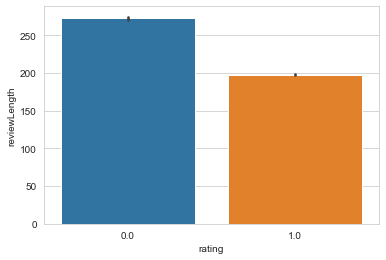

In [ ]:
sns.barplot("rating", "reviewLength", data=df_train)

В среднем отрицательные отзывы длиннее положительных. 

##### summary

Проведем анализ, аналогичный анализу предудущего столбца. 

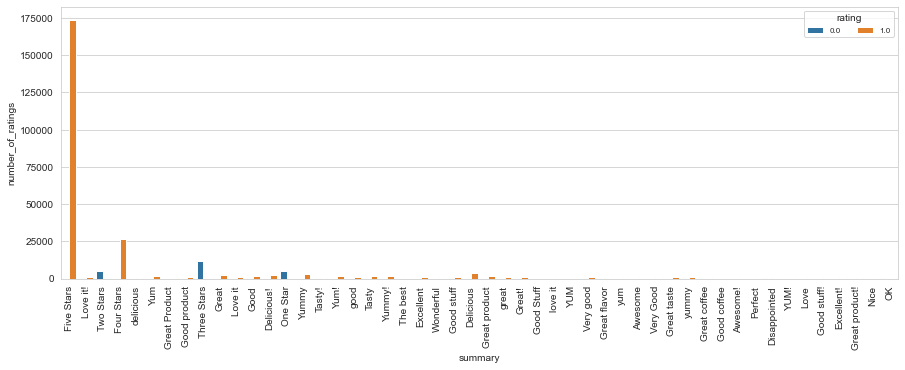

In [ ]:
countplot_2(df_train[df_train.summary.isin(df_train.summary.value_counts().index[:50])], 'summary', size = (15, 5), rotation = 90)

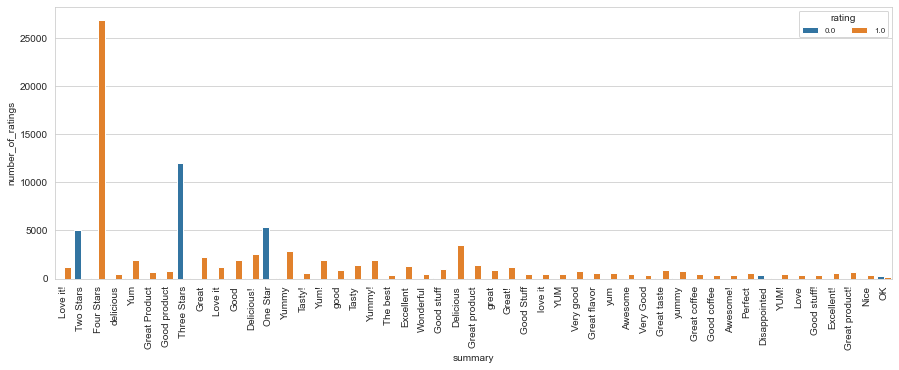

In [ ]:
countplot_2(df_train[df_train.summary.isin(df_train.summary.value_counts().index[1:50])], 'summary', size = (15, 5), rotation = 90)

In [ ]:
# Создание столбца с длиной сжатого отзыва
df_train['summaryLength'] = df_train['summary'].apply(lambda x: len(str(x)))

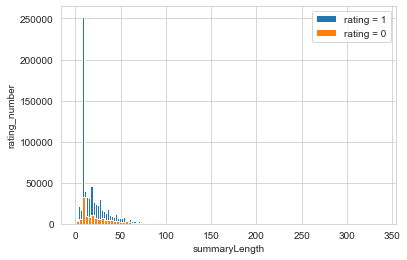

In [ ]:
hist_2(df_train, 'summaryLength')

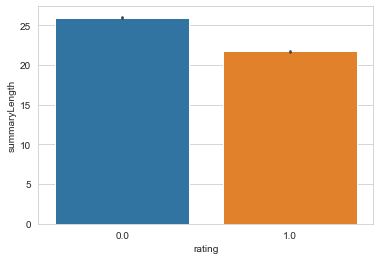

In [ ]:
sns.barplot("rating", "summaryLength", data=df_train)

##### userid

"Радикальные" пользователи

Существуют пользователи, которые делают исключительно положительные оценки (rating = 1) ("поклонники") или, наоборот, только отрицательные оценки (rating = 0) ("хейтеры").

In [ ]:
# ID "пользователей-радикалов", "поклонников" и "хейтеров"
radical_users = set(df_train.userid) - (set(df_train[df_train.rating == 1].userid) & set(df_train[df_train.rating == 0].userid))
fans = set(df_train[df_train.userid.isin(radical_users) & (df_train.rating == 1)].userid)
haters = set(df_train[df_train.userid.isin(radical_users) & (df_train.rating == 0)].userid)

В качестве примера выведем 10 ID "хейтеров":

In [ ]:
list(haters)[100:110]

[123156, 74009, 41244, 123171, 123173, 123184, 98624, 41288, 123210, 98637]

Посмотрим, к примеру, на "хейтера" с ID = 123184:

In [ ]:
df_train[df_train.userid == 123184]

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day_of_week,reviewLength,summaryLength
35162,1.0,False,2017-09-05,B008QMX2SG,Randa K. McFadden,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,NaN,NaN,NaN,123184,24556,0.0,2017,9,1,100,42
86121,1.0,True,2017-09-05,B019EGM8UA,Randa,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,2,"{'Size:': ' 12 Bars', 'Flavor:': ' Dark Chocol...",NaN,123184,36332,0.0,2017,9,1,100,42
104585,1.0,True,2017-09-05,B008QMX2SG,Randa,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,2,NaN,NaN,123184,24556,0.0,2017,9,1,100,42
210813,1.0,True,2017-09-05,B00R7PWK7W,Randa K. McFadden,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,2,NaN,NaN,123184,32046,0.0,2017,9,1,100,42
283654,1.0,True,2017-09-05,B00TBUHRRO,Randa,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,NaN,NaN,NaN,123184,32566,0.0,2017,9,1,100,42
552403,1.0,True,2017-09-05,B00D3M2QP4,Randa,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,2,"{'Size:': ' 12 Bars', 'Flavor:': ' Dark Chocol...",NaN,123184,23540,0.0,2017,9,1,100,42
586681,1.0,False,2017-09-05,B00D3M2QP4,Randa,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,NaN,"{'Size:': ' 12 Bars', 'Flavor:': ' Caramel Alm...",NaN,123184,23540,0.0,2017,9,1,100,42
626372,1.0,True,2017-09-05,B00E1P4L1Y,Randa,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,NaN,NaN,NaN,123184,24360,0.0,2017,9,1,100,42
687179,1.0,True,2017-09-05,B00BUKL666,Randa K. McFadden,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,2,NaN,NaN,123184,22208,0.0,2017,9,1,100,42
712282,1.0,False,2017-09-05,B00R7PWK7W,Randa K. McFadden,"The product is not fresh. It tastes good, but...","It tastes good, but very hard to bite into",1504569600,NaN,NaN,NaN,123184,32046,0.0,2017,9,1,100,42


Как мы видим, пользователь поставил 10 отрицательных оценок и ни одной положительной.

Посмотрим на количество таких "радикалов" и их активность.

In [ ]:
print('Количество всех пользователей - ', len(set(df_train.userid)))
print('Количество "радикальных" пользователей - ', len(radical_users))
print('Количество "поклонников" - ', len(fans))
print('Количество "хейтеров" - ', len(haters))

Количество всех пользователей -  127448
Количество "радикальных" пользователей -  69298
Количество "поклонников" -  67610
Количество "хейтеров" -  1688


In [ ]:
print('Количество всех оценок -', len(df_train))
print('Количество оценок от всех "радикальных" пользователей - ', len(df_train[df_train.userid.isin(radical_users)]))
print('Количество оценок от "поклонников" - ', len(df_train[df_train.userid.isin(fans)]))
print('Количество оценок от "хейтеров" - ', len(df_train[df_train.userid.isin(haters)]))

Количество всех оценок - 857895
Количество оценок от всех "радикальных" пользователей -  381050
Количество оценок от "поклонников" -  374637
Количество оценок от "хейтеров" -  6413


In [ ]:
print('Количество оценок, в среднем приходящихся на одного пользователя')
print('В общем - ', "%.2f" % float(len(df_train)/len(set(df_train.userid))), 'оценок/чел.')
print('Обычный пользователь (не "радикал") - ', "%.2f" % float(len(df_train[~df_train.userid.isin(radical_users)])/(len(set(df_train.userid)) - len(radical_users))), 'оценок/чел.')
print('"Радикальный" пользователь - ', "%.2f" % float(len(df_train[df_train.userid.isin(radical_users)])/len(radical_users)), 'оценок/чел.')
print('"Поклонник" - ', "%.2f" % float(len(df_train[df_train.userid.isin(fans)])/len(fans)), 'оценок/чел.')
print('"Хейтер" - ', "%.2f" % float(len(df_train[df_train.userid.isin(haters)])/len(haters)), 'оценок/чел.')      

Количество оценок, в среднем приходящихся на одного пользователя
В общем -  6.73 оценок/чел.
Обычный пользователь (не "радикал") -  8.20 оценок/чел.
"Радикальный" пользователь -  5.50 оценок/чел.
"Поклонник" -  5.54 оценок/чел.
"Хейтер" -  3.80 оценок/чел.


Оказывается, таких "радикалов" очень много - больше половины всех пользователей (54%).

Среди всех "радикалов" доля "поклонников" составляет 98,3%, а "хейтеров", соответственно - менее 2%.

При этом "радикалы" менее активны, чем обычные пользователи, причем "хейтеры" менее активны, чем "поклонники".

Полученные данные подтверждаются графически - ниже представлено распределение количества пользователей в зависимости от среднего рейтинга, который они присваивают оцениваемым товарам:

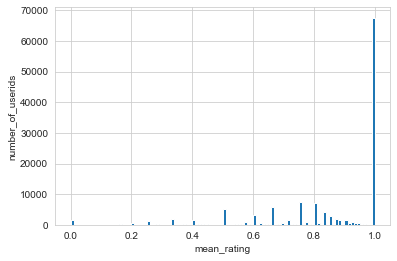

In [ ]:
hist_1(df_train, 'userid')

##### itemid

По аналогии с "радикальными" пользователями проанализируем "радикальные" товары - "хорошие" (которые оценивают исключительно положительно) и "плохие" (которые оценивают только отрицательно).

In [ ]:
radical_items = set(df_train.itemid) - (set(df_train[df_train.rating == 1].itemid) & set(df_train[df_train.rating == 0].itemid))
good_products = set(df_train[df_train.itemid.isin(radical_items) & (df_train.rating == 1)].itemid)
bad_products = set(df_train[df_train.itemid.isin(radical_items) & (df_train.rating == 0)].itemid)

In [ ]:
print('Количество всех товаров - ', len(set(df_train.itemid)))
print('Количество "радикальных" товаров - ', len(radical_items))
print('Количество "хороших" товаров - ', len(good_products))
print('Количество "плохих" товаров - ', len(bad_products))

Количество всех товаров -  41302
Количество "радикальных" товаров -  12191
Количество "хороших" товаров -  12061
Количество "плохих" товаров -  130


Распределение количества товаров по их среднему рейтингу:

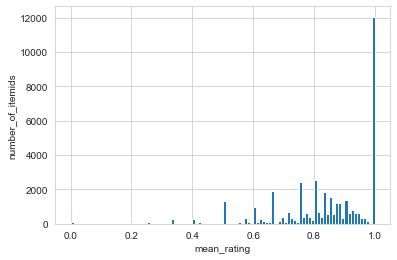

In [ ]:
hist_1(df_train, 'itemid')

## 3. Предобработка данных <a name="preproc"></a>

##### Дубликаты

Дубликаты по всем столбцам

In [11]:
all_col_dupl = df_train[df_train.duplicated(keep=False)]

In [21]:
all_col_dupl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61783 entries, 11 to 857891
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         61783 non-null  float64
 1   verified        61783 non-null  bool   
 2   reviewTime      61783 non-null  object 
 3   asin            61783 non-null  object 
 4   reviewerName    61759 non-null  object 
 5   reviewText      61773 non-null  object 
 6   summary         61775 non-null  object 
 7   unixReviewTime  61783 non-null  int64  
 8   vote            9505 non-null   object 
 9   style           32347 non-null  object 
 10  image           325 non-null    object 
 11  userid          61783 non-null  int64  
 12  itemid          61783 non-null  int64  
 13  rating          61783 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 6.7+ MB


Дубликаты по столбцам 'userid', 'itemid', 'rating'

In [12]:
col_dupl = df_train[df_train.duplicated(subset = ['userid', 'itemid', 'rating'], keep=False)]

In [23]:
col_dupl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84268 entries, 8 to 857891
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         84268 non-null  float64
 1   verified        84268 non-null  bool   
 2   reviewTime      84268 non-null  object 
 3   asin            84268 non-null  object 
 4   reviewerName    84244 non-null  object 
 5   reviewText      84254 non-null  object 
 6   summary         84257 non-null  object 
 7   unixReviewTime  84268 non-null  int64  
 8   vote            12763 non-null  object 
 9   style           48994 non-null  object 
 10  image           464 non-null    object 
 11  userid          84268 non-null  int64  
 12  itemid          84268 non-null  int64  
 13  rating          84268 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 9.1+ MB


Количество дубликатов по всем столбцам - 61783

Количество дубликатов по столбцам 'userid', 'itemid', 'rating' - 84268

Три дубликата, отличающиеся только текстом отзыва:

In [24]:
col_dupl.sort_values(by='userid').tail(3)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
797847,5.0,True,"08 4, 2016",B00ZW60PCA,"EuiTaek, Y.",Taste so good,Five Stars,1470268800,NaN,{'Style:': ' Acai Berry'},NaN,127495,41097,1.0
134934,5.0,True,"08 4, 2016",B00ZW60PCA,"EuiTaek, Y.",Goog,Five Stars,1470268800,NaN,{'Style:': ' Goji Berry'},NaN,127495,41097,1.0
142161,5.0,True,"08 4, 2016",B00ZW60PCA,"EuiTaek, Y.",Good,Five Stars,1470268800,NaN,{'Style:': ' Cranberry'},NaN,127495,41097,1.0


Дубликаты, отличающиеся датами отзывов, их верификацией, полными и сжатыми текстами отзывов:

In [25]:
df_train[(df_train.userid == 29228) & (df_train.itemid == 5629) & (df_train.rating == 1.0)]

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
8,5.0,True,"01 25, 2013",B00117YT4Y,Surra,"I have tried a few other brands, but this powd...",low carb goodness,1359072000,NaN,"{'Size:': ' 12 ounce', 'Flavor:': ' Gourmet Ch...",NaN,29228,5629,1.0
621511,5.0,False,"01 20, 2013",B00117YT4Y,Surra,I actually love this brand because\na) belnds ...,love it with milk,1358640000,NaN,"{'Size:': ' 12 ounce', 'Flavor:': ' Double Cho...",NaN,29228,5629,1.0


In [26]:
col_dupl['rating'].value_counts()

1.0    73999
0.0    10269
Name: rating, dtype: int64

Видно, что дубликаты по столбцам 'userid', 'itemid', 'rating' в большинстве случаев не имеют отличий по другим столбцам, а если и имеют, то эти отличия несущественны. Кроме того, распределение рейтинга по дубликатам аналогично распределению рейтинга по всему датафрейму. Таким образом, имеет смысл удалить дубликаты по столбцам 'userid', 'itemid', 'rating'.

Дубликаты по столбцам 'userid' и 'itemid', но с различным значением 'rating'

Встречаются такие "подозрительные" дубликаты, в которых один и тот же пользователь по-разному оценил один и тот же item.

In [27]:
# Подозрительные пользователи
suspicious_users = set(df_train[train.duplicated(subset = ['userid', 'itemid'])].userid) - set(df_train[df_train.duplicated(subset = ['userid', 'itemid', 'rating'])].userid)
len(suspicious_users)

626

In [28]:
# Подозрительные товары
suspicious_items = set(df_train[train.duplicated(subset = ['userid', 'itemid'])].itemid) - set(df_train[df_train.duplicated(subset = ['userid', 'itemid', 'rating'])].itemid)
len(suspicious_items)

103

In [29]:
# Подозрительные оценки
suspicious_ratings = df_train[df_train.duplicated(subset = ['userid', 'itemid'], keep = False) & df_train.userid.isin(suspicious_users) & df_train.itemid.isin(suspicious_items)].sort_values(by = ['userid', 'itemid'])
len(suspicious_ratings)

124

In [30]:
suspicious_ratings.head(6)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
104370,4.0,True,"07 3, 2016",B00F06O3LG,Sunshine,Great taste ver unquie we enjoyed them throughly,Four Stars,1467504000,NaN,{'Style:': ' Ice Cream'},NaN,2120,25097,1.0
619539,2.0,True,"07 3, 2016",B00F06O3LG,Sunshine,Not up to the standarss of Godiva. Very disap...,Two Stars,1467504000,NaN,{'Style:': ' Caramel'},NaN,2120,25097,0.0
96055,5.0,True,"04 13, 2018",B00WBHJ1Y6,Edmond,Truly unique taste. You can taste the espress...,Truly unique taste. You can taste the espresso...,1523577600,NaN,{'Style:': ' Dirty'},NaN,2309,33571,1.0
738829,3.0,True,"04 13, 2018",B00WBHJ1Y6,Edmond,"It's ok. I really couldn't taste the coconut,...",but the chai was good.,1523577600,NaN,{'Style:': ' Coconut Thai'},NaN,2309,33571,0.0
333490,4.0,True,"12 10, 2013",B0000DKQ59,Gopher,Good flavor but it takes a lot to give that va...,Good Flavor & No Alcohol.,1386633600,NaN,{'Size:': ' Pack of 1'},NaN,3268,125,1.0
798343,3.0,True,"10 2, 2013",B0000DKQ59,Gopher,This still has a slight chemical taste but is ...,"This is the best I've found. Underwhelmed, bu...",1380672000,NaN,NaN,NaN,3268,125,0.0


Таким образом, имеет смысл удалить дубликаты по столбцам 'userid', 'itemid','rating'

###### Формирование item_features

In [8]:
import json

In [9]:
recipes = [json.loads(line) for line in open('meta_Grocery_and_Gourmet_Food.json', 'r')]

In [10]:
df_json = pd.DataFrame(recipes)

In [11]:
df_json = df_json[df_json.asin.isin(set(df_json.asin) & set(train.asin))]

In [12]:
mapper = dict(zip(train.asin, train.itemid))

In [13]:
df_json['itemid'] = df_json['asin'].apply(lambda x: mapper[x])
df_json.head()

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit,itemid
10,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Tea use only the finest t...,Lipton Yellow Label Tea (loose tea) - 450g,Lipton,"30,937inGroceryGourmetFood(","[B00CREXSHY, B001QTRGAQ, B000JSQK70, B002EYZM4...",Grocery,$12.46,4639725043,"[B00886E4K0, B00CREXSHY, B001QTRGAQ, B002EYZM4...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,1
11,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Teabags uses a new way to...,Lipton Yellow Label Finest Blend Tea Bags 100 ...,Lipton,"15,487inGroceryGourmetFood(","[B000JSQDK4, B007ZI1SKG, B00286KM8E, B01LY2304...",Grocery,$12.98,4639725183,"[B000JSQDK4, B007ZI1SKG, 4639725043, B00KPFHOP...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,0
15,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","[20 Sachets, Empty contents into cup\nPour 8oz...",Organo Gold Cafe Supreme 100% Certified Ganode...,Organo Gold,"89,943inGroceryGourmetFood(","[B003CGJAIM, B00F3XJX6G, B01LVXI1GP, B00E1C3FJ...",Grocery,$29.90,5463213682,"[B00F3XJX6G, B003CY45VG, B003CGJAIM, B00E1C3FJ...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,2
42,"[Grocery & Gourmet Food, Sauces, Gravies & Mar...","[Mae Ploy Thai green curry paste., Ingredients...","Mae Ploy Green Curry Paste, 14 oz",Mae Ploy,"39,261inGroceryGourmetFood(","[B002P8AQJ0, B000EICISA, B0091UW4QS, B006VD15F...",Grocery,NaN,9742356831,"[B000EICJWA, B000EICISA, B074ZMGQNT, B0044PYPV...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,3
44,"[Grocery & Gourmet Food, Cooking & Baking, Foo...",[This set is a great value from one of the gre...,"Ateco Food Coloring Kit, 6 colors",Harold Import Company,">#257,139 in Kitchen & Dining (See Top 100 in ...","[B00KCUXRLC, B0026N2Y3U, B01BZ5U3Y6, B01DWEZB5...",Amazon Home,NaN,B00004S1C5,NaN,NaN,"June 6, 2006","[Six certified gel colors included - black, bl...",NaN,NaN,NaN,NaN,4


In [14]:
df_json['brand'].fillna('Unknown_brand', inplace = True)

In [15]:
for i in range(4):
    df_json[f'cat_{i}'] = df_json['category'].apply(lambda x: x[i] if len(x)>=i+1 else "Unknown") 

In [16]:
df_json[['itemid', 'main_cat', 'brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3']].head()

,itemid,main_cat,brand,cat_0,cat_1,cat_2,cat_3
10,1,Grocery,Lipton,Grocery & Gourmet Food,Beverages,"Coffee, Tea & Cocoa",Tea
11,0,Grocery,Lipton,Grocery & Gourmet Food,Beverages,"Coffee, Tea & Cocoa",Tea
15,2,Grocery,Organo Gold,Grocery & Gourmet Food,Beverages,"Coffee, Tea & Cocoa",Coffee
42,3,Grocery,Mae Ploy,Grocery & Gourmet Food,"Sauces, Gravies & Marinades",Sauces,Asian
44,4,Amazon Home,Harold Import Company,Grocery & Gourmet Food,Cooking & Baking,Food Coloring,Unknown


In [17]:
df_json.cat_0.unique()

array(['Grocery & Gourmet Food'], dtype=object)

In [18]:
df_json.drop('cat_0', axis = 1, inplace = True)

In [19]:
brand_dict = {}
main_cat_dict = {} 
cat_1_dict = {}
cat_2_dict = {}
cat_3_dict = {}

In [20]:
for num, brand in enumerate(df_json.brand.unique()):
    brand_dict[brand] = num
for num, main_cat in enumerate(df_json.main_cat.unique()):
    main_cat_dict[main_cat] = num + len(brand_dict)
for num, cat_1 in enumerate(df_json.cat_1.unique()):
    cat_1_dict[cat_1] = num + len(brand_dict) + len(main_cat_dict) 
for num, cat_2 in enumerate(df_json.cat_2.unique()):
    cat_2_dict[cat_2] = num + len(brand_dict) + len(main_cat_dict) + len(cat_1_dict)
for num, cat_3 in enumerate(df_json.cat_3.unique()):
    cat_3_dict[cat_3] = num + len(brand_dict) + len(main_cat_dict) + len(cat_1_dict) + + len(cat_2_dict)

In [21]:
cols = ['brand', 'main_cat', 'cat_1', 'cat_2', 'cat_3']
dicts = [brand_dict, main_cat_dict, cat_1_dict, cat_2_dict, cat_3_dict]

In [22]:
for col, dic in zip(cols, dicts):
    df_json[col + '_id'] = df_json[col].apply(lambda x: dic[x])

In [23]:
df_brand = df_json[['itemid', 'brand_id']]
df_brand.columns = ['itemid', 'id']
df_main_cat = df_json[['itemid', 'main_cat_id']]
df_main_cat.columns = ['itemid', 'id']
df_cat_1 = df_json[['itemid', 'cat_1_id']]
df_cat_1.columns = ['itemid', 'id']
df_cat_2 = df_json[['itemid', 'cat_2_id']]
df_cat_2.columns = ['itemid', 'id']
df_cat_3 = df_json[['itemid', 'cat_3_id']]
df_cat_3.columns = ['itemid', 'id']

In [24]:
df_brand.id.unique()

array([   0,    1,    2, ..., 8864, 8865, 8866])

In [25]:
df_main_cat.id.unique()

array([8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877,
       8878, 8879, 8880, 8881, 8882, 8883, 8884])

In [26]:
df_cat_1.id.unique()

array([8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895,
       8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906,
       8907, 8908, 8909])

In [27]:
df_cat_2.id.unique()

array([8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920,
       8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931,
       8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940, 8941, 8942,
       8943, 8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8952, 8953,
       8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964,
       8965, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8974, 8975,
       8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986,
       8987, 8988, 8989, 8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997,
       8998, 8999, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008,
       9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019,
       9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027, 9028, 9029, 9030,
       9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041,
       9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052,
       9053, 9054, 9055, 9056, 9057, 9058, 9059, 90

In [28]:
df_cat_3.id.unique()

array([9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135,
       9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146,
       9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157,
       9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168,
       9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179,
       9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190,
       9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201,
       9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212,
       9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223,
       9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234,
       9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245,
       9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256,
       9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267,
       9268, 9269, 9270, 9271, 9272, 9273, 9274, 92

In [29]:
df_items_1 = df_brand

In [30]:
df_items_2 = pd.concat([df_items_1, df_main_cat])

In [31]:
df_items_3 = pd.concat([df_items_2, df_cat_1])

In [32]:
df_items_4 = pd.concat([df_items_3, df_cat_2])

In [33]:
df_items_5 = pd.concat([df_items_4, df_cat_3])

### 4. Создание и обучение моделей <a name="model"></a>

In [34]:
pip install lightfm

     |████████████████████████████████| 307kB 5.2MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=707620 sha256=78e03298751b8e8406d7dc58616fdaf23f8a37e15bf715ea826e7d614abe6bcd
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [35]:
from lightfm import LightFM
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightfm.evaluation import auc_score
import scipy.sparse as sparse
import scipy

In [36]:
RANDOM_SEED = 42

## 4.1. Чистая коллаборативная фильрация <a name="collab"></a>

Определяем функцию для обучения модели:

In [37]:
def ml_lightfm(df_train_input, 
               df_test_input = pd.DataFrame({'A' : []}), 
               kaggle = pd.DataFrame({'A' : []}),
               lr = 0.1, 
               los='logistic', 
               num_components = 30,
               num_epochs = 20, 
               num_threads = 4,
               users = pd.DataFrame({'A' : []}), 
               items = pd.DataFrame({'A' : []}), 
               version = None):
    train_data = df_train_input.copy()
    if type(users) == scipy.sparse.coo.coo_matrix:
        user_matrix = users
    elif users.empty == False:
        user_matrix = sparse.coo_matrix(([1]*len(users), (users.userid, users.id)))
    else:
        user_matrix = None
    if items.empty == False:
        item_matrix = sparse.coo_matrix(([1]*len(items), (items.itemid, items.id)))
    else:
        item_matrix = None
    ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))    
    model = LightFM(learning_rate=lr, loss=los,
                no_components=num_components, random_state = RANDOM_SEED)
    model = model.fit(ratings_coo, epochs=num_epochs, 
                  num_threads=num_threads, user_features = user_matrix, item_features = item_matrix)
    preds_train = model.predict(train_data.userid.values,
                      train_data.itemid.values, user_features = user_matrix, item_features = item_matrix)
    train_metrics_skl = roc_auc_score(train_data.rating, preds_train)
    print('Тренировочные данные:')
    print("AUC ROC sklearn - ", train_metrics_skl)
    if df_test_input.empty == False:
        test_data = df_test_input.copy()
        preds_test = model.predict(test_data.userid.values,
                      test_data.itemid.values, user_features = user_matrix, item_features = item_matrix)
        test_metrics_skl = roc_auc_score(test_data.rating, preds_test)
        print('Валидационные данные:')
        print("AUC ROC sklearn - ", test_metrics_skl)   
    if kaggle.empty == False:
        preds = model.predict(kaggle.userid.values,
                      kaggle.itemid.values, user_features = user_matrix, item_features = item_matrix)
        normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
        submission = pd.DataFrame(kaggle.Id)
        submission['rating']= normalized_preds
        submission.to_csv(f'submission_{version}.csv', index=False)
        return model

Обучаем модель на необработанных тренировочных данных

C предварительным разбиением на тренировочную и валидационную части:

In [17]:
train, test = train_data, test_data = train_test_split(df_train.copy(),
                                                       random_state = RANDOM_SEED, 
                                                       shuffle=True)

In [ ]:
ml_lightfm(train, df_test_input = test)

Тренировочные данные:
AUC ROC sklearn -  0.9987403154699417
Валидационные данные:
AUC ROC sklearn -  0.7459392243216268


Обучаем модель с теми же параметрами на всех данных и предсказываем результаты на тестовых данных для Kaggle:

In [ ]:
model_1 = ml_lightfm(df_train.copy(), kaggle = df_test.copy(), version = 1)

Тренировочные данные:
AUC ROC sklearn -  0.9993879519607652


AUC ROC на Kaggle - 0.76312

Производим аналогичные действия с данными, предварительно удалив из них дубликаты по столбцам 'userid', 'itemid','rating':

In [ ]:
train_df = df_train.copy()
train_df.drop_duplicates(subset = ['userid', 'itemid','rating'], inplace = True)

In [ ]:
train, test = train_data, test_data = train_test_split(train_df.copy(),
                                                       random_state = RANDOM_SEED, 
                                                       shuffle=True)

In [ ]:
ml_lightfm(train, df_test_input = test)

Тренировочные данные:
AUC ROC sklearn -  0.9982685686705232


In [ ]:
model_2 = ml_lightfm(train_df, kaggle = df_test.copy(), version = 2)

AUC ROC на тренировочных данных -  0.9991379340357627


AUC ROC на Kaggle - 0.76222

## 4.2. Гибридные модели <a name="hybrid"></a>

Добавим разные варианты item_features:

In [ ]:
train, test = train_data, test_data = train_test_split(df_train.copy(),
                                                       random_state = RANDOM_SEED, 
                                                       shuffle=True)

In [ ]:
ml_lightfm(train, df_test_input = test, items = df_items_1)

Тренировочные данные:
AUC ROC sklearn -  0.9992602958094252
Валидационные данные:
AUC ROC sklearn -  0.7201876664752804


In [ ]:
model_3 = ml_lightfm(df_train.copy(), items = df_items_1, kaggle = df_test.copy(), version = 3)

Тренировочные данные:
AUC ROC sklearn -  0.9990471592938849


AUC ROC на Kaggle - 0.74068

In [ ]:
ml_lightfm(train, df_test_input = test, items = df_items_2)

Тренировочные данные:
AUC ROC sklearn -  0.9990972924912573
Валидационные данные:
AUC ROC sklearn -  0.7267240563854879


In [ ]:
model_4 = ml_lightfm(df_train.copy(), items = df_items_2, kaggle = df_test.copy(), version = 4)

Тренировочные данные:
AUC ROC sklearn -  0.9989445876084357


AUC ROC на Kaggle - 0.74964

In [ ]:
ml_lightfm(train, df_test_input = test, items = df_items_3)

Тренировочные данные:
AUC ROC sklearn -  0.9993230687380433
Валидационные данные:
AUC ROC sklearn -  0.7212424995507469


In [ ]:
model_5 = ml_lightfm(df_train.copy(), items = df_items_3, kaggle = df_test.copy(), version = 5)

Тренировочные данные:
AUC ROC sklearn -  0.9991109497682629


AUC ROC на Kaggle - 0.74201

In [ ]:
ml_lightfm(train, df_test_input = test, items = df_items_4)

Тренировочные данные:
AUC ROC sklearn -  0.9995868671255226
Валидационные данные:
AUC ROC sklearn -  0.7232648173304135


In [ ]:
model_6 = ml_lightfm(df_train.copy(), items = df_items_4, kaggle = df_test.copy(), version = 6)

Тренировочные данные:
AUC ROC sklearn -  0.9994074011238653


AUC ROC на Kaggle - 0.74352

In [ ]:
ml_lightfm(train, df_test_input = test, items = df_items_5)

Тренировочные данные:
AUC ROC sklearn -  0.9997324288325145
Валидационные данные:
AUC ROC sklearn -  0.7218643994181435


In [ ]:
model_7 = ml_lightfm(df_train.copy(), items = df_items_5, kaggle = df_test.copy(), version = 7)

Тренировочные данные:
AUC ROC sklearn -  0.9996151707839168


###### users_features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

In [ ]:
text_df = pd.DataFrame({'userid': list(set(df_train.userid))})

In [ ]:
def summary_sum(cell):
    sub_df = df_train[df_train.userid == cell]
    text = ''
    for i in range(len(sub_df)):
        text += ' ' + sub_df['summary'].fillna('NaN').iloc[i] 
    return text

In [ ]:
text_df['summary_texts'] = text_df['userid'].apply(summary_sum)

In [ ]:
text_df

,userid,summary_texts
0,0,Consistently High Quality Five Stars
1,1,Hard to decorate lolly pops. Love these. It's...
2,2,its okay. Not for me Wonderful MORE MORE MORE...
3,3,"You must drink this, if you call yourself a t..."
4,4,Did not mention aspartame content. No MSG Thi...
...,...,...
127443,127491,You will not be disappointed! Five Stars Five...
127444,127492,Five Stars Five Stars Five Stars Five Stars F...
127445,127493,"These are good, a bit heavy fish oil flavor b..."
127446,127494,Two Stars Had for 2 months and it still leaks...


In [ ]:
text_df_add = pd.DataFrame({'userid' :  list(set(text_df.index) - (set(text_df.index) & set(text_df.userid)))}) 

In [ ]:
text_df_add['summary_texts'] = ''

In [ ]:
df_text = pd.concat([text_df, text_df_add])

In [ ]:
df_text = df_text.sort_values(by = 'userid').reset_index(drop = True)

In [ ]:
summary_texts_sparse = CountVectorizer(ngram_range=(1, 3), stop_words = 'english').fit_transform(df_text['summary_texts'])

In [ ]:
summary_texts_sparse

<127496x1888082 sparse matrix of type '<class 'numpy.int64'>'
	with 4911145 stored elements in Compressed Sparse Row format>

In [ ]:
users_sparse  = sparse.coo_matrix(([1]*len(df_train),(df_train.userid,df_train.userid)))

In [ ]:
users_sparse

<127496x127496 sparse matrix of type '<class 'numpy.int32'>'
	with 857895 stored elements in COOrdinate format>

In [ ]:
df_train.userid.nunique()

127448

In [ ]:
df_users = hstack([users_sparse, summary_texts_sparse])

In [ ]:
df_users

<127496x2015578 sparse matrix of type '<class 'numpy.int64'>'
	with 5769040 stored elements in COOrdinate format>

In [ ]:
model_8 = ml_lightfm(df_train.copy(), kaggle = df_test.copy(), users = df_users, version = 18)

Тренировочные данные:
AUC ROC sklearn -  0.70142248926049


AUC ROC на Kaggle - 0.52098

Добавление фичей пользователей и товаров ухудшает AUC ROC

## 5. Выбор модели и подбор гиперпараметров <a name="params"></a>

Добавление фичей пользователей и товаров ухудшает AUC ROC. Поэтому для обучения модели используем только исходную матрицу взаимодействий "пользователь-товар". При этом варьируем длину эмбеддингов.

In [ ]:
num_comp = [] #список, в который были добавлены длины эмбеддингов в диапазоне от 1 до 200 
vers = []  #список с номерами моделей

for i in range(len(num_comp)):
    train, test = train_data, test_data = train_test_split(df_train.copy(),
                                                       random_state = RANDOM_SEED, 
                                                       shuffle=True)
    print('num_components =', num_comp[i])
    ml_lightfm(train, df_test_input = test, num_components = num_comp[i])
    ml_lightfm(df_train.copy(), kaggle = df_test.copy(), 
               num_components = num_comp[i],version = vers[i])

В итоге получили оптимальную длину эмбеддинга. Она равна 115.

In [45]:
train, test = train_data, test_data = train_test_split(df_train.copy(),
                                                       random_state = RANDOM_SEED, 
                                                       shuffle=True)
model = ml_lightfm(df_train.copy(), kaggle = df_test.copy(), 
               num_components = 115,version = '')

Тренировочные данные:
AUC ROC sklearn -  0.9991290607179298


## 6. Получение эмбеддингов <a name="embeddings"></a>

In [41]:
pip install nmslib

     |████████████████████████████████| 13.0MB 324kB/s 
     |████████████████████████████████| 194kB 5.8MB/s 


In [42]:
import nmslib
import pickle

In [46]:
item_biases, item_embeddings = model.get_item_representations()

In [47]:
# граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши товары в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [48]:
#Вспомогательная функция для поиска по графу
def nearest_items_nms(item_id, index, n=10):
    nn = index.knnQuery(item_embeddings[item_id], k=n)
    return nn

In [49]:
nbm = nearest_items_nms(100,nms_idx)[0]

In [50]:
#Товары, похожие на товар с id = 10:
df_json[df_json.itemid.isin(nbm)]

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit,itemid,cat_1,cat_2,cat_3,brand_id,main_cat_id,cat_1_id,cat_2_id,cat_3_id
661,"[Grocery & Gourmet Food, Sauces, Gravies & Mar...",[This sauce claims to be the hottest on Earth!...,"DA BOMB Ground Zero, 4 fl oz",Original Juan,"28,073inGroceryGourmetFood(","[B000FIBBWS, B00170LPPQ, B0037V0N74, B016L0VRM...",Grocery,$9.50,B0000DG56P,"[B001BIXK7K, B000FIBBWS, B00170LPPQ, B000VZSRW...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,100,"Sauces, Gravies & Marinades",Hot Sauce,Unknown,59,8867,8886,8944,9128
4358,"[Grocery & Gourmet Food, Sauces, Gravies & Mar...",[This sauce claims to be the hottest on Earth!...,"DA BOMB Ground Zero, 4 fl oz",Original Juan,"28,073inGroceryGourmetFood(","[B000FIBBWS, B00170LPPQ, B0037V0N74, B016L0VRM...",Grocery,$9.50,B0000DG56P,"[B001BIXK7K, B000FIBBWS, B00170LPPQ, B000VZSRW...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,100,"Sauces, Gravies & Marinades",Hot Sauce,Unknown,59,8867,8886,8944,9128
23952,"[Grocery & Gourmet Food, Cooking & Baking, Coo...",[We know Dad will understand that you enjoy ma...,"Newman's Own Organic Extra Virgin Olive Oil, 2...",Newman's Own,NaN,"[B005CT8R90, B000QW6ULK, B000QV6TDK, B076JMVL6...",Grocery,NaN,B000QWAC78,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,4263,Cooking & Baking,"Cooking Oils, Vinegars & Sprays",Oils,263,8867,8887,8923,9142
24312,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...","[For over 75 years, Hain Pure Foods has been p...","Hain, Sea Salt, 26 oz",Hain,"141,965inGroceryGourmetFood(","[B000MDACSK, B000R5PKCQ, B0083JVXA6, B00KPX1C9...",Grocery,$8.97,B000R6QRBS,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,4339,"Herbs, Spices & Seasonings",Salt & Salt Substitutes,Sea Salt,402,8867,8890,8917,9221
40834,"[Grocery & Gourmet Food, Cooking & Baking, Pud...",[Original homemade taste. Easy to open and res...,var aPageStart = (new Date()).getTime();\nvar ...,Kraft,"57,988inGroceryGourmetFood(",NaN,Grocery,$30.00,B001EPPC0I,"[B00CBHR1NY, B00891G9AC, B0000TA3BW, B00DDJY8H...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,7958,Cooking & Baking,Pudding & Gelatin,Pudding,649,8867,8887,8955,9175
88911,"[Grocery & Gourmet Food, Cooking & Baking, Bak...",[Bake life sweeter with Betty Crocker cake mix...,Betty Crocker Super Moist Cake Mix Golden Vani...,Betty Crocker,"105,992inGroceryGourmetFood(",NaN,Grocery,$14.70,B005EKI15M,"[B0029K307E, B078GW3DQ1, B00DJQ2C62, B00CWPULE...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,39669,Cooking & Baking,Baking Mixes,Cakes,492,8867,8887,8937,9154
89695,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...",[Blue Diamond Almond and Coconut milk blendis ...,"Almond Breeze AlmondmIlk, Almond and Coconut B...",Blue Diamond Almonds,"428,071inGroceryGourmetFood(",NaN,Grocery,NaN,B005FPDENA,NaN,NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,15879,"Dairy, Cheese & Eggs",Milk Substitutes,Almond Milk,977,8867,8892,9054,9544
110321,"[Grocery & Gourmet Food, Snack Foods, Nuts & S...",[GIANTS new Kettle Roast is one of the most ex...,Kettle Roast Salty Sweet Flavored Sunflower Se...,GIANTS,"22,180inGroceryGourmetFood(",NaN,Grocery,$24.00,B007PPOPNG,"[B00XF6AA10, B073WCLMCM, B079V198P1, B000P583Y...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,18804,Snack Foods,Nuts & Seeds,Unknown,1526,8867,8888,8928,9128
192670,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Assorted pack

In [4]:
with open('item_embeddings.pickle', 'wb') as file:
   pickle.dump(item_embeddings, file)

NameError: ignored

## 7. Проблема холодного старта <a name="start"></a>

LightFM, как и другие рекоментадельные алгоритмы, не позволяет выдавать рекомендации абсолютно новым пользователям в том случае, если о них отсутствует дополнительная информация. Проблема может быть решена путем описания пользователей признаками, которые алгорим использует во время обучения. Например, модель обучается на пользователях с ID от 0 до 10, а рекомендацию нужно выдать пользователю с ID 11. Если кроме ID о новом пользователе ничего неизвестно, алгоритм будет неспособен к рекомендации, т.к. ничего неизвестно о предпочтениях нового пользователя. Однако предположим, что имеются некоторые признаки, с помощью которых можно описывать пользователей: возможно, в процессе регистрации каждый пользователь выбирает определенное количество интересующих его объектов (фильмы ужасов или романтические комедии, например). Если эти признаки присутствуют в процессе обучения модели, алгоритм может "выучить" какие предпочтения в среднем связаны с этими характеристиками, и будет способен осуществлять рекомендации по отношению к любым новым пользователям, которые могут быть описаны признаками такого же характера. В представленном примере выдать рекомендации пользователю с ID 11 можно в том случае, если в наличии есть предпочтения, которые он выбрал во время регистрации. В реализации LightFM все эти признаки будут закодированы в матрицы, возможно, путем one-hot encoding. Для выдачи рекомендаций пользователю 11 нужно сконструировать новую матрицу признаков для этого пользователя: пока эта матрица признаков содержит только признаки, присутствующие в процесс обучения модели, будет возможной выдача рекомендаций. Заметим, что обычно полезно иметь признак, который соответствует только одному пользователю: 'Is user 0', 'Is user 1' и т.д. В случае новых пользователей ткой признак бесполезен, так как в процессе обучения модели отсутствует информация, которую она может использовать.

## Выводы <a name="end"></a>

1. Проведен разведочный анализ данных. Показано, что существуют пользователи, выставляющие только положительные или только отрицательные оценки товарам, а также товары, у которых нет отрицательных, или, наоборот, положительных отзывов.
2. Обучены модели, основанные на матричной факторизации, а также content-based модели. Показано, что добавление метаинформации о пользователях и товарах снижает score на kaggle.
3. Получены эмбеддинги пользователей и товаров в виде сумм векторов скрытых признаков и смещений, которые можно трактовать как поправки на оптимизм/пессимизм пользователя при оценке товаров и на изначальное мнение о товаре (возможно, из-за его брэнда и т.д.)
4. Показаны пути решения проблемы холодного старта. Установлено, что решение этой проблемы возможно в случае, если имеется метаинформация о пользователях и товарах. 

## Источники <a name="literature"></a>

1. Исходный код библиотеки lightfm https://github.com/lyst/lightfm
2. Maciej Kula. Metadata Embeddings for User and Item Cold-start Recommendations. 2015. https://arxiv.org/abs/1507.08439
3. https://making.lyst.com/lightfm/docs/index.html
4. https://stackoverflow.com/questions/46924119/lightfm-handling-user-and-item-cold-start
5. https://www.kaggle.com/niyamatalmass/lightfm-hybrid-recommendation-system
